
# Cleaning the Data and Model Evaluation: Loan Default 
---


References:

1- Loan Default Dataset by M Yasser H: https://www.kaggle.com/datasets/yasserh/loan-default-dataset  Uploaded under CC0 licence.

2- Predicting Loan Defaults by Bayesian.Terrapin https://www.kaggle.com/code/bayesianterrapin/predicting-loan-defaults Shared under Apache 2.0 licence.

3- ROC and AUC by Akbar Huseynov https://www.kaggle.com/code/akbarhuseynov23/roc-and-auc Shared under Apache 2.0 licence.



In [320]:
# from google.colab import drive

# drive.mount('/content/drive')

In [321]:
import pandas as pd

data = pd.read_csv('DataLoan.csv' ) #change path if needed


In [322]:
data.head()

,ID,amount,Interest_rate_spread,loan_limit,loan_purpose,property_value,income,Gender,business_or_commercial,default
0,127451,266500,0.6664,cf,p3,518000.0,5760.0,Non-binary,nob/c,0
1,47873,456500,0.8255,cf,p1,478000.0,4920.0,Male,b/c,0
2,143258,216500,NaN,cf,no info,218000.0,NaN,Male,b/c,1
3,82415,856500,0.3007,ncf,p1,1108000.0,12360.0,Non-binary,nob/c,0
4,146580,116500,NaN,ncf,p3,NaN,4860.0,Male,nob/c,1


In [323]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      60000 non-null  int64  
 1   amount                  60000 non-null  int64  
 2   Interest_rate_spread    45208 non-null  float64
 3   loan_limit              58665 non-null  object 
 4   loan_purpose            59939 non-null  object 
 5   property_value          53856 non-null  float64
 6   income                  56279 non-null  float64
 7   Gender                  60000 non-null  object 
 8   business_or_commercial  60000 non-null  object 
 9   default                 60000 non-null  int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 4.6+ MB


In [324]:
data.isnull().sum()

ID                            0
amount                        0
Interest_rate_spread      14792
loan_limit                 1335
loan_purpose                 61
property_value             6144
income                     3721
Gender                        0
business_or_commercial        0
default                       0
dtype: int64

There are null values in the dataset as it is not cleaned. To visualise the distribution of the null values, we use Missingno library: https://github.com/ResidentMario/missingno.

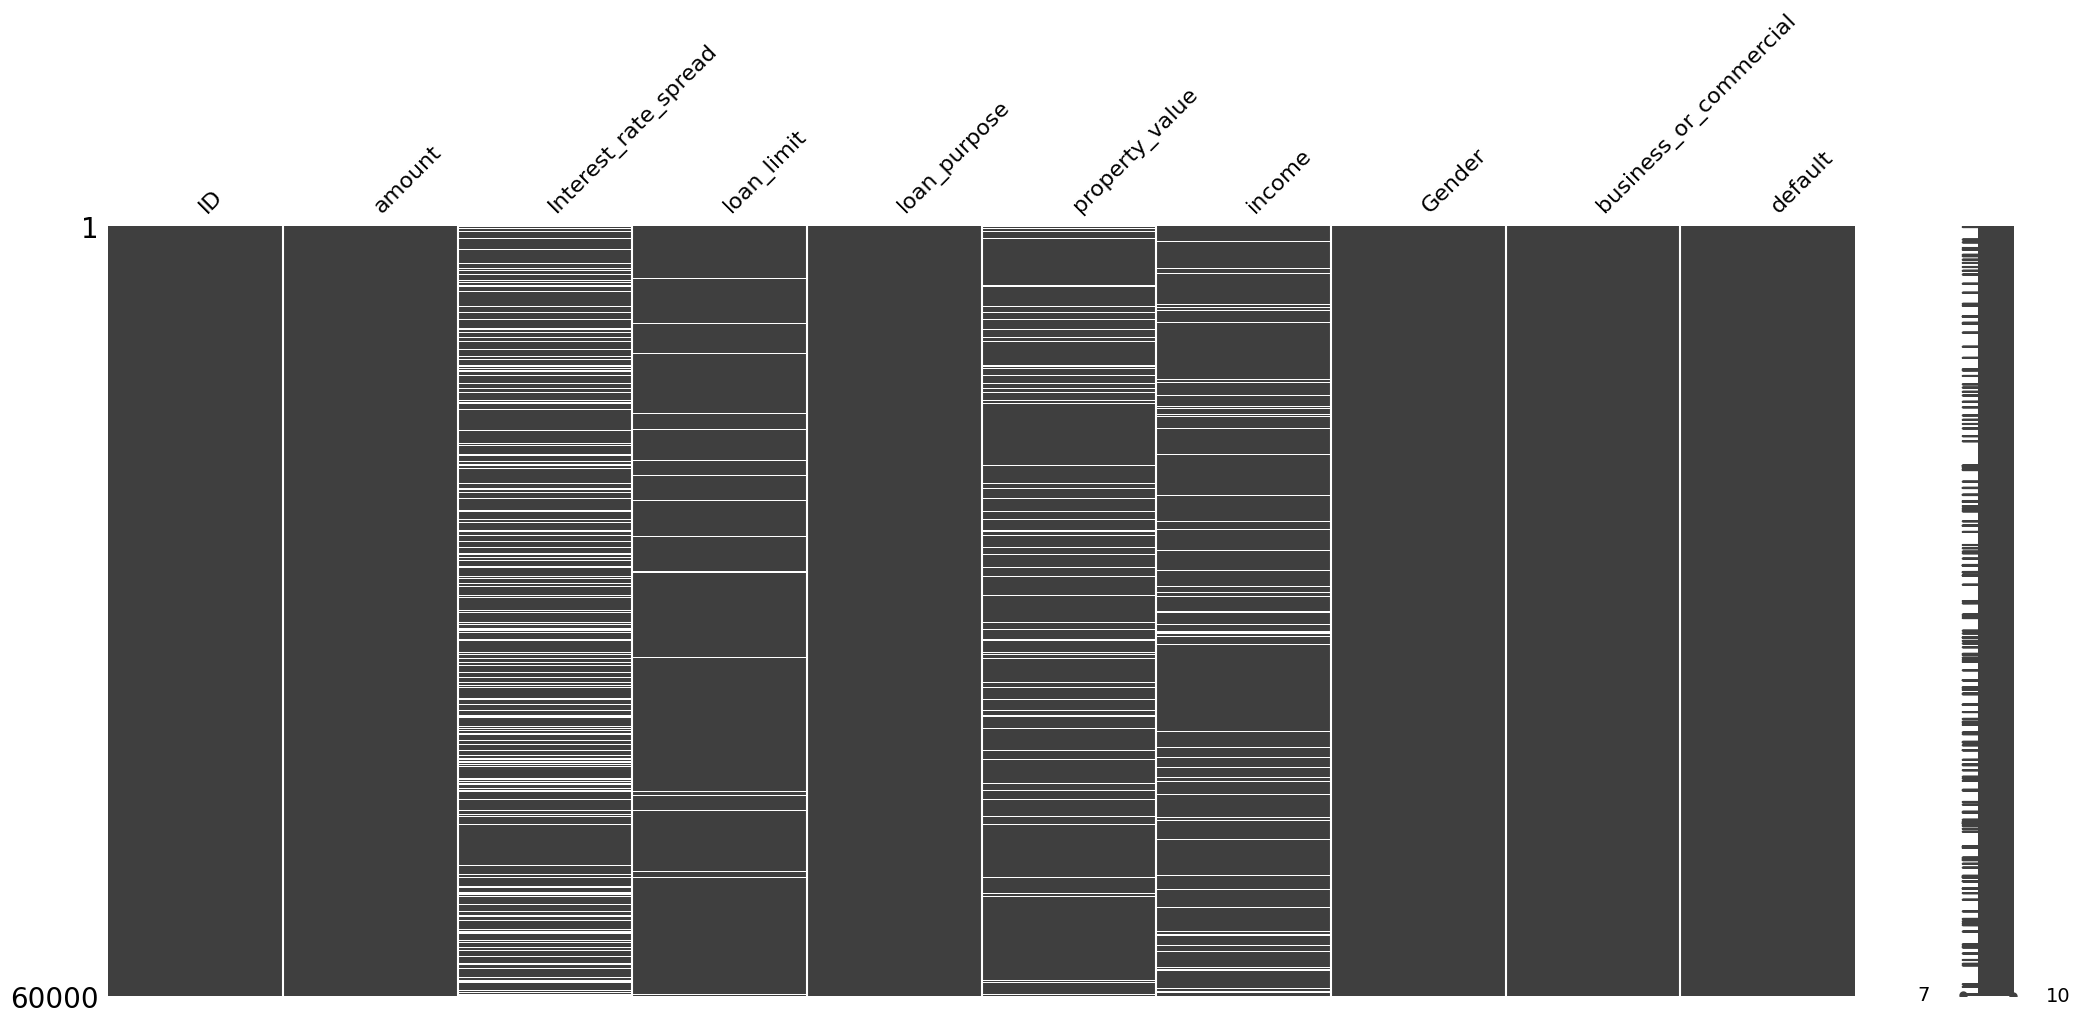

<Figure size 1300x1000 with 0 Axes>

In [325]:
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(data)
plt.figure(figsize = (13,10))
plt.show()

The white parts are the explicit missing values in the main plots. The bar on the left shows the concentration of missing values in the different rows for the different indicators. It also contains two numbers that show the minimum completeness and the maximum completeness among the rows. Here, the minimun completeness shows that there are some rows that just contain data from 7 columns and the rest are missing.

### Handling the missing values

In [326]:
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
numerical_data = data[numerical_columns]
numerical_data.isnull().sum()

ID                          0
amount                      0
Interest_rate_spread    14792
property_value           6144
income                   3721
default                     0
dtype: int64

As we see, there are 3 indicators with missing values among the numerical columns. To fill those missing cells, we use K Nearest Neighbor imputer. This method looks for a set of other rows (neighbors) that have closest values for the non-missing indicators to our target row. After finding them, it performs an averaging on the inidicator that we miss in our target row in those neighbors. Finally, it fills the missing value of our target row with the average.

KNN Imputer : https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html and https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm.

In our implementation, we use 3 neighbors for imputation. Using more neighbors may provide better results ( also results in higher runtime)

In [327]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
imputed_numerical_data = imputer.fit_transform(numerical_data)

Transform the output of KNNImputer is not a Pandas dataframe by default, we have to transform it to a dataframe:

In [328]:
imputed_numerical_data = pd.DataFrame(imputed_numerical_data, columns=numerical_columns)

In [329]:
imputed_numerical_data.isnull().sum()

ID                      0
amount                  0
Interest_rate_spread    0
property_value          0
income                  0
default                 0
dtype: int64

In [330]:
imputed_numerical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    60000 non-null  float64
 1   amount                60000 non-null  float64
 2   Interest_rate_spread  60000 non-null  float64
 3   property_value        60000 non-null  float64
 4   income                60000 non-null  float64
 5   default               60000 non-null  float64
dtypes: float64(6)
memory usage: 2.7 MB


As we see, there are no numerical missing values in the output. Let's have a look on the categorical indicators.

In [331]:
categorical_columns = data.select_dtypes(include=['object']).columns
categorical_data = data[categorical_columns]

In [332]:
categorical_data.isnull().sum()

loan_limit                1335
loan_purpose                61
Gender                       0
business_or_commercial       0
dtype: int64

As we see, there are two categorical indicators with 'explicit' missing values. However, it is very common that we have 'implicit' missing values in categorical data as well. These are basically the cells that are not left empty, instead it is written in them that they do not have data; for example, by writing "No data exists" in that cell.

To check for implicit missing values, we print all the unique objects that exist for every categorical indicator.

In [333]:
for i in range(len(categorical_columns)):
    print(categorical_columns[i],data[categorical_columns[i]].unique())

loan_limit ['cf' 'ncf' nan]
loan_purpose ['p3' 'p1' 'no info' 'p2' nan]
Gender ['Non-binary' 'Male' 'Female' 'Sex Not Available']
business_or_commercial ['nob/c' 'b/c']


As we see, we have 'no info' in loan purpose column and 'Sex Not Available' in Gender column that indicate implicit missing values. We use NumPy library to replace them with NaN, which makes them explicit and update our categorical data.

In [334]:
import numpy as np

data['Gender'] = data['Gender'].replace('Sex Not Available', np.nan)
data['loan_purpose'] = data['loan_purpose'].replace('no info', np.nan)

categorical_data = data[categorical_columns]

In [335]:
categorical_data.isnull().sum()

loan_limit                 1335
loan_purpose              22138
Gender                    15075
business_or_commercial        0
dtype: int64

We see that we have 3 categorical indicators with missing values indeed.

To impute these missing values, we use the mode of the relevant columns. As the mode shows the most common category in each of these indicators, it can be a good choice for imputation of null cells.

In [336]:
imputed_categorical_data = categorical_data

for i in categorical_columns:
    mode = categorical_data[i].mode()
    mode = mode[0]
    imputed_categorical_data[i].fillna(value=mode, inplace=True)

C:\Users\berrayan\AppData\Local\Temp\ipykernel_11724\3646380817.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  imputed_categorical_data[i].fillna(value=mode, inplace=True)
C:\Users\berrayan\AppData\Local\Temp\ipykernel_11724\3646380817.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imputed_categorical_data[i].fillna(value=mode, inpla

In [337]:
imputed_categorical_data.isnull().sum()

loan_limit                0
loan_purpose              0
Gender                    0
business_or_commercial    0
dtype: int64

In [338]:
imputed_categorical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   loan_limit              60000 non-null  object
 1   loan_purpose            60000 non-null  object
 2   Gender                  60000 non-null  object
 3   business_or_commercial  60000 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


Now as we handeled the missing data in numerical indicators and categorical indicators, we concatinate them and perform final checking.

In [339]:
imputed_data = pd.concat([imputed_categorical_data, imputed_numerical_data], axis=1, join='inner')

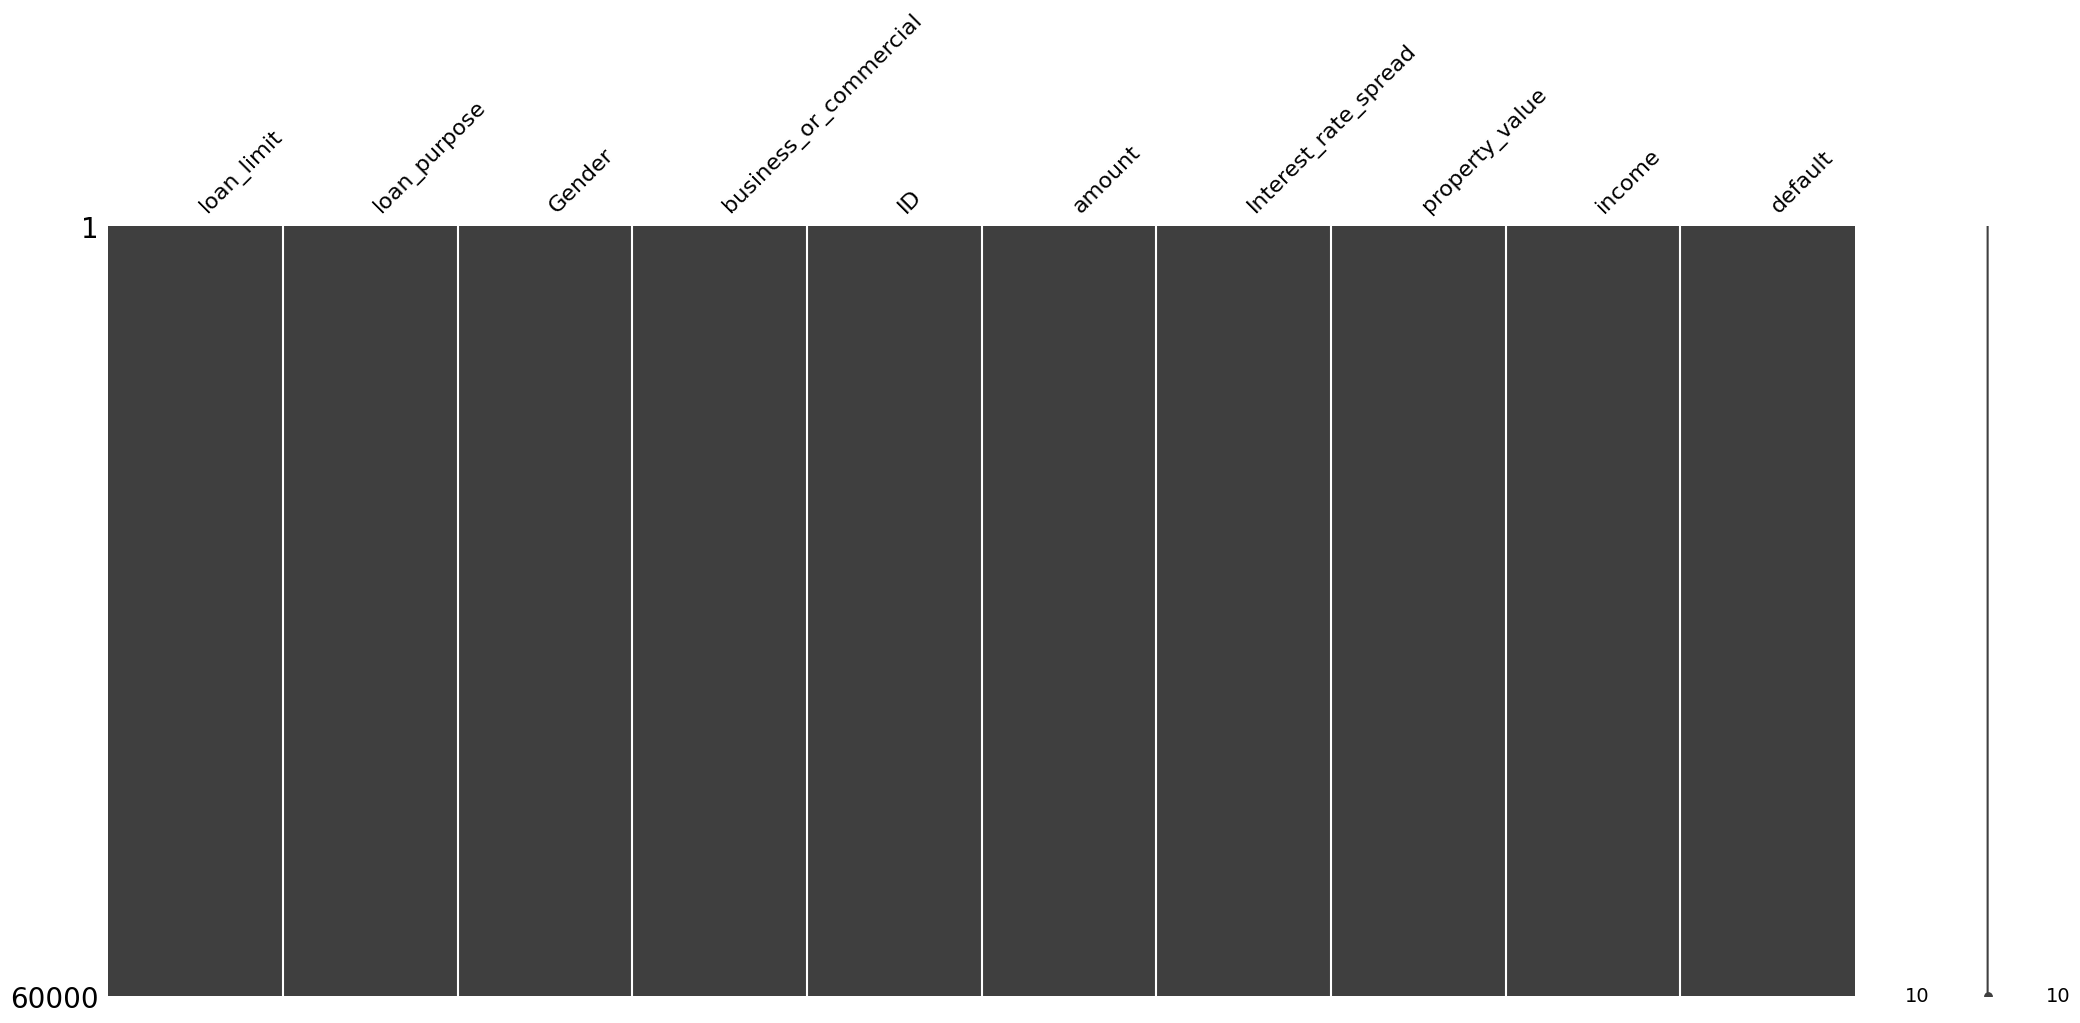

<Figure size 1300x1000 with 0 Axes>

In [340]:
msno.matrix(imputed_data)
plt.figure(figsize = (13,10))
plt.show()

In [341]:
imputed_data.head()

,loan_limit,loan_purpose,Gender,business_or_commercial,ID,amount,Interest_rate_spread,property_value,income,default
0,cf,p3,Non-binary,nob/c,127451.0,266500.0,0.666400,5.180000e+05,5760.0,0.0
1,cf,p1,Male,b/c,47873.0,456500.0,0.825500,4.780000e+05,4920.0,0.0
2,cf,p3,Male,b/c,143258.0,216500.0,0.906033,2.180000e+05,2460.0,1.0
3,ncf,p1,Non-binary,nob/c,82415.0,856500.0,0.300700,1.108000e+06,12360.0,0.0
4,ncf,p3,Male,nob/c,146580.0,116500.0,0.592500,3.446667e+05,4860.0,1.0


# !!!!!!!!!!!!!!!!!!!!!!! Preprocessing and fitting a model

To encode the string values in categorical indicators to numerical values ye use One Hot Encoding and we implement it using Pandas: https://en.wikipedia.org/wiki/One-hot and https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html  .

In [342]:
imputed_encoded_categorical_data = pd.get_dummies(imputed_categorical_data)

Here we show a few lines of the one hot encoded data. As we see, since we have 10 unique string objects in our 4 categorical columns (look at the unique objects that we printed before), it makes 10 columns and fill them with 1 when they have that specific object.

In [343]:
imputed_encoded_categorical_data.head()

,loan_limit_cf,loan_limit_ncf,loan_purpose_p1,loan_purpose_p2,loan_purpose_p3,Gender_Female,Gender_Male,Gender_Non-binary,business_or_commercial_b/c,business_or_commercial_nob/c
0,True,False,False,False,True,False,False,True,False,True
1,True,False,True,False,False,False,True,False,True,False
2,True,False,False,False,True,False,True,False,True,False
3,False,True,True,False,False,False,False,True,False,True
4,False,True,False,False,True,False,True,False,False,True


Afterwards, we concatenate the encoded categorical data with numerical data.

In [344]:
imputed_data = pd.concat([imputed_encoded_categorical_data, imputed_numerical_data], axis=1, join='inner')

In [345]:
imputed_data.head()

,loan_limit_cf,loan_limit_ncf,loan_purpose_p1,loan_purpose_p2,loan_purpose_p3,Gender_Female,Gender_Male,Gender_Non-binary,business_or_commercial_b/c,business_or_commercial_nob/c,ID,amount,Interest_rate_spread,property_value,income,default
0,True,False,False,False,True,False,False,True,False,True,127451.0,266500.0,0.666400,5.180000e+05,5760.0,0.0
1,True,False,True,False,False,False,True,False,True,False,47873.0,456500.0,0.825500,4.780000e+05,4920.0,0.0
2,True,False,False,False,True,False,True,False,True,False,143258.0,216500.0,0.906033,2.180000e+05,2460.0,1.0
3,False,True,True,False,False,False,False,True,False,True,82415.0,856500.0,0.300700,1.108000e+06,12360.0,0.0
4,False,True,False,False,True,False,True,False,False,True,146580.0,116500.0,0.592500,3.446667e+05,4860.0,1.0


We divide the dataset by train_test_split function from Scikitlearn: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html .

The output of this dataset is default. Whether a user has a loan default or not.

In [346]:
from sklearn.model_selection import train_test_split

imputed_data.columns = imputed_data.columns.astype(str)

train_set, test_set = train_test_split(imputed_data, test_size=0.2, random_state=8)

y_train = train_set['default']
X_train = train_set.drop(columns=['default'])
y_test = test_set['default']
X_test = test_set.drop(columns=['default'])

We fit a Decision Tree Classifier and a Random Forest Classifier on training set and test them on testing set.

In [347]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

model_rf = RandomForestClassifier()
model_rf.fit(X=X_train, y=y_train);

model_dt = DecisionTreeClassifier()
model_dt.fit(X=X_train, y=y_train);

model_xgb = XGBClassifier()
model_xgb.fit(X=X_train, y=y_train);

In [348]:
model_dt.score(X=X_test, y=y_test)

0.6920833333333334

In [349]:
model_rf.score(X=X_test, y=y_test)

0.776

In [350]:
model_xgb.score(X=X_test, y=y_test)

0.7891666666666667

We see that our Random Forest Classifier provides a better accuracy than the deicision tree classifier. However, the 'score' function uses a default 0.5 confidence threshold for evaluation and it does not help us to check the effectiveness of our model in other confidence threshold in case we need a more conservative or permissive model.
(Best one is XGBoost)

#  Evaluating of the effectiveness of the model in different confidence thresholds

To evaluate a model for different thresholds, we need to manually output the probabilities that our models produce for classification of every user.

In [351]:
model_rf_probs = model_rf.predict_proba(X_test)

model_rf_probs = model_rf_probs[:, 1]

In [352]:
model_dt_probs = model_dt.predict_proba(X_test)

model_dt_probs = model_dt_probs[:, 1]

In [353]:
model_xgb_probs = model_xgb.predict_proba(X_test)
model_xgb_probs = model_xgb_probs[:, 1]

Now that we have the probabilites, we can plot the ROC curves that show us the True Positive Rate vs. False Positive Rate of a model, when we change the confidence threshold.

C:\Users\berrayan\AppData\Local\Temp\ipykernel_11724\4172085493.py:9: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  plt.plot(model_dt_fpr, model_dt_tpr, 's', marker='o',color='darkorange', label='Decision Tree Classifier')


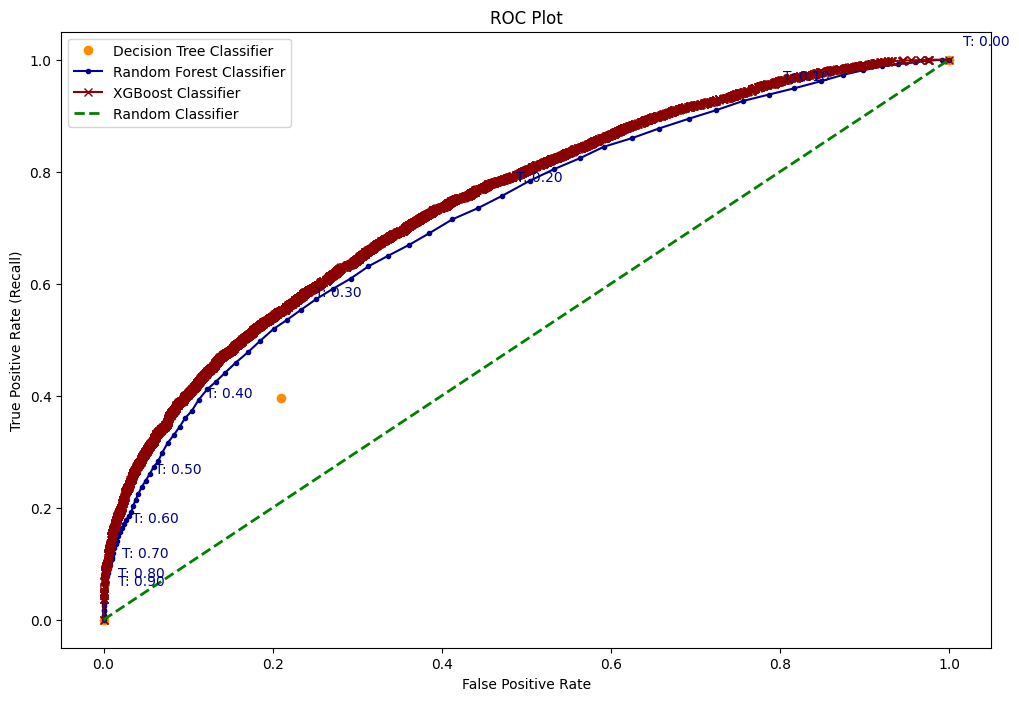

In [354]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

model_dt_fpr, model_dt_tpr, _ = roc_curve(y_test, model_dt_probs)
model_rf_fpr, model_rf_tpr, model_rf_thresholds = roc_curve(y_test, model_rf_probs)
model_xgb_fpr, model_xgb_tpr, model_xgb_thresholds = roc_curve(y_test, model_xgb_probs)

plt.figure(figsize=(12, 8))
plt.plot(model_dt_fpr, model_dt_tpr, 's', marker='o',color='darkorange', label='Decision Tree Classifier')
plt.plot(model_rf_fpr, model_rf_tpr, marker='.',color='darkblue', label='Random Forest Classifier')
plt.plot(model_xgb_fpr, model_xgb_tpr, marker='x',color='darkred', label='XGBoost Classifier')
for i in range(0, len(model_rf_thresholds), len(model_rf_thresholds)//10):
    if 1>=model_rf_thresholds[i]>=0:
      plt.annotate(f'T: {model_rf_thresholds[i]:.2f}', (model_rf_fpr[i], model_rf_tpr[i]),color='darkblue', textcoords="offset points", xytext=(10,10), ha='left')
plt.plot([0, 1], [0, 1], color='green', lw=2, linestyle='--', label='Random Classifier')


plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend()
plt.show()

In this plot, the left side show a more conservative model that produces less false positive predictions with the cost of less true positive predictions and the right side shows a more permissive model that produces more true positive predictions with the cost of more false positive predictions.

The dashed green line shows a completely random classifier that always produce the same rate of true positive and false positive.

The orange dots show the decision tree classifier. As decision tree is a discrete classifier that only outputs a class label (either 1 or 0 for with loan default and without loan default in this case), changing the confidance threshold between 0 and 1 does not change the result and the result is always the orange dot in the center. However, as random forest is an ranking classifier that its result is made voting of an ensemble of decision tress, by changing the confidence threshold we can have access to different true positive rates and false positive rates. For all the models, when the threshold reaches 0 and less than 0, the true positive rate and false positive rates both reach 1, that means the model just predicts that every one has a lone loan default. On the other side, when the probablity threshold reaches 1 and beyond 1, it means that the models predict that nobody has a loan default.

The models that are closer to the top-left point are stronger as they can provide more true positive predicition without having many false positive predicitions.

### RANDOM FOREST

To have access to different classification thresholds, we can set it manually instead of using 'score' function. We then show the accuracy using the 'classification report'. We do this for the Random Forest Classifier

In [355]:
from sklearn.metrics import classification_report

threshold = 0.5
predicted_classes = (model_rf_probs >= threshold).astype(int)
print(classification_report(y_test, predicted_classes))

              precision    recall  f1-score   support

         0.0       0.79      0.96      0.87      9013
         1.0       0.64      0.24      0.34      2987

    accuracy                           0.78     12000
   macro avg       0.71      0.60      0.61     12000
weighted avg       0.75      0.78      0.74     12000



As we see, when the threshold is equal to 0.5, the accuracy is the same as 'score' function output, since 'score' uses the same threshold. To check the true positive rate and false positive rate of a model with this threshold, we use confusion matrix. 

In [356]:
from sklearn.metrics import confusion_matrix

CM = confusion_matrix(y_test, predicted_classes)

print(CM)

[[8608  405]
 [2280  707]]


In [357]:
TN, FP, FN, TP = CM.ravel()

TPR = TP / (TP + FN)

print("True Positive Rate:", TPR)

FPR = FP / (FP + TN)

print("False Positive Rate:", FPR)

FNR = FN / (FN + TP)

print("False Negative Rate:", FNR)

TNR = TN / (TN + FP)

print("True Negative Rate:", TNR)

True Positive Rate: 0.23669233344492802
False Positive Rate: 0.044935093753467215
False Negative Rate: 0.763307666555072
True Negative Rate: 0.9550649062465328


In order to have a more permissive model that provides a higher rate of true positives, we can set a lower threshold. The opposite can be done if we need a more conservative threshold. We set the threshold equal to 0.1 .

In [358]:
threshold = 0.1

predicted_classes = (model_rf_probs >= threshold).astype(int)

print(classification_report(y_test, predicted_classes))

              precision    recall  f1-score   support

         0.0       0.91      0.21      0.35      9013
         1.0       0.28      0.94      0.43      2987

    accuracy                           0.39     12000
   macro avg       0.60      0.58      0.39     12000
weighted avg       0.76      0.39      0.37     12000



In [359]:
CM = confusion_matrix(y_test, predicted_classes)

print(CM)

[[1921 7092]
 [ 186 2801]]


In [360]:
TN, FP, FN, TP = CM.ravel()

TPR = TP / (TP + FN)

print("True Positive Rate:", TPR)

FPR = FP / (FP + TN)

print("False Positive Rate:", FPR)

FNR = FN / (FN + TP)

print("False Negative Rate:", FNR)

TNR = TN / (TN + FP)

print("True Negative Rate:", TNR)

True Positive Rate: 0.9377301640441915
False Positive Rate: 0.7868634195051593
False Negative Rate: 0.062269835955808504
True Negative Rate: 0.2131365804948408


We see that using this permissive threshold, we can have higher number of true positive classifications. This comes with a cost of higher false positive rate.

The opposite can be done if we need a more conservative threshold.

In [361]:
threshold = 0.9

predicted_classes = (model_rf_probs >= threshold).astype(int)

print(classification_report(y_test, predicted_classes))

              precision    recall  f1-score   support

         0.0       0.76      1.00      0.86      9013
         1.0       0.98      0.04      0.07      2987

    accuracy                           0.76     12000
   macro avg       0.87      0.52      0.47     12000
weighted avg       0.81      0.76      0.67     12000



In [362]:
CM = confusion_matrix(y_test, predicted_classes)

print(CM)

[[9011    2]
 [2878  109]]


In [363]:
TN, FP, FN, TP = CM.ravel()

TPR = TP / (TP + FN)

print("True Positive Rate:", TPR)

FPR = FP / (FP + TN)

print("False Positive Rate:", FPR)

FNR = FN / (FN + TP)

print("False Negative Rate:", FNR)

TNR = TN / (TN + FP)

print("True Negative Rate:", TNR)

True Positive Rate: 0.0364914630063609
False Positive Rate: 0.00022190169754798624
False Negative Rate: 0.9635085369936391
True Negative Rate: 0.999778098302452


Happyyy :) : low false positive rate because it means low loss !!

+++ let's access to 'area under curve (AUC)' of our random forest model for the ROC plot using Scikit Learn. It is a powerfull indicator that shows the effectiveness of a model for different confidence thresholds and it can be used as an effective tool for comparison of models. More info at https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html

In [364]:
from sklearn.metrics import roc_auc_score

model_rf_auc = roc_auc_score(y_test, model_rf_probs)

print( model_rf_auc)

0.7223125351318044


### XGBoost 

In [365]:
threshold = 0.5

predicted_classes = (model_xgb_probs >= threshold).astype(int)

print(classification_report(y_test, predicted_classes))

CM = confusion_matrix(y_test, predicted_classes)

print(CM)

TN, FP, FN, TP = CM.ravel()

TPR = TP / (TP + FN)

print("True Positive Rate:", TPR)

FPR = FP / (FP + TN)

print("False Positive Rate:", FPR)

FNR = FN / (FN + TP)

print("False Negative Rate:", FNR)

TNR = TN / (TN + FP)

print("True Negative Rate:", TNR)

              precision    recall  f1-score   support

         0.0       0.80      0.97      0.87      9013
         1.0       0.71      0.25      0.38      2987

    accuracy                           0.79     12000
   macro avg       0.76      0.61      0.62     12000
weighted avg       0.78      0.79      0.75     12000

[[8709  304]
 [2226  761]]
True Positive Rate: 0.2547706729159692
False Positive Rate: 0.03372905802729391
False Negative Rate: 0.7452293270840308
True Negative Rate: 0.9662709419727061


In [366]:
threshold = 0.9

predicted_classes = (model_xgb_probs >= threshold).astype(int)

print(classification_report(y_test, predicted_classes))

CM = confusion_matrix(y_test, predicted_classes)

print(CM)

TN, FP, FN, TP = CM.ravel()

TPR = TP / (TP + FN)

print("True Positive Rate:", TPR)

FPR = FP / (FP + TN)

print("False Positive Rate:", FPR)

FNR = FN / (FN + TP)

print("False Negative Rate:", FNR)

TNR = TN / (TN + FP)

print("True Negative Rate:", TNR)

              precision    recall  f1-score   support

         0.0       0.76      1.00      0.86      9013
         1.0       0.96      0.05      0.10      2987

    accuracy                           0.76     12000
   macro avg       0.86      0.53      0.48     12000
weighted avg       0.81      0.76      0.67     12000

[[9006    7]
 [2825  162]]
True Positive Rate: 0.05423501841312354
False Positive Rate: 0.0007766559414179519
False Negative Rate: 0.9457649815868765
True Negative Rate: 0.999223344058582


Ohh False Positive Rate is less good than Random Forest

In [367]:
model_xgb_auc = roc_auc_score(y_test, model_xgb_probs)

print( model_xgb_auc)

0.7462204186632031


## Naive Bayes model, because why not try

In [368]:
from sklearn.naive_bayes import GaussianNB

model_nb = GaussianNB()
model_nb.fit(X=X_train, y=y_train)

GaussianNB()

In [369]:
Y_pred = model_nb.predict(X_test)

print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

         0.0       0.75      0.99      0.85      9013
         1.0       0.39      0.02      0.04      2987

    accuracy                           0.75     12000
   macro avg       0.57      0.51      0.45     12000
weighted avg       0.66      0.75      0.65     12000



The model correctly classified 75% of the instances overall. Which is much better than expected !

Let's compare ROC curve with other models: 

C:\Users\berrayan\AppData\Local\Temp\ipykernel_11724\94546817.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  plt.plot(model_dt_fpr, model_dt_tpr, 's', marker='o',color='darkorange', label='Decision Tree Classifier')


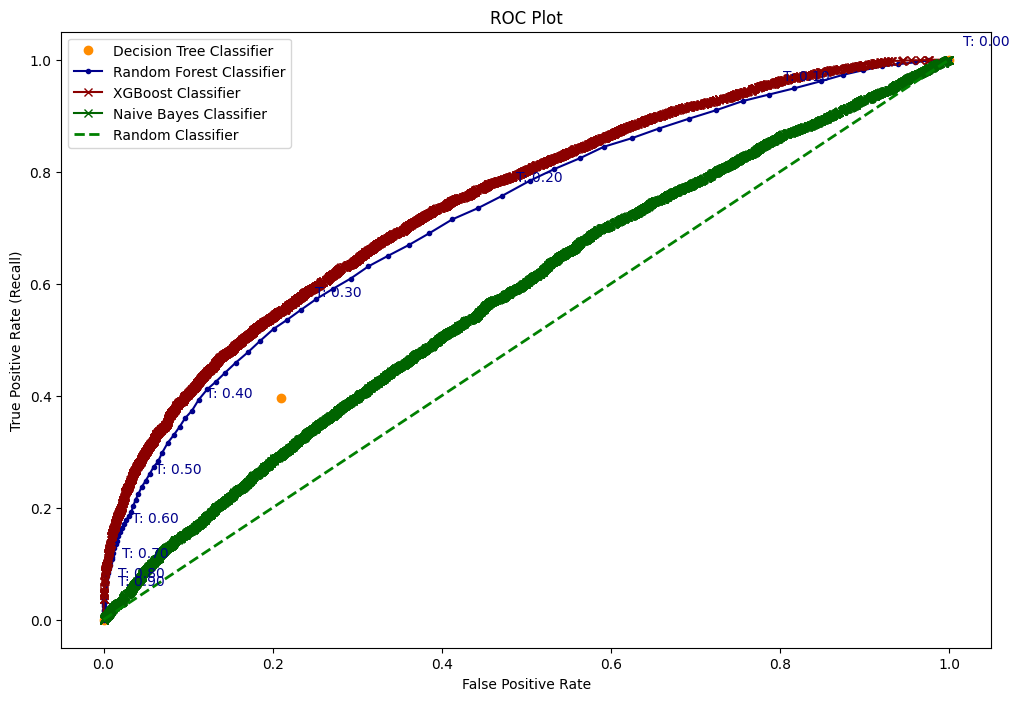

In [370]:
model_nb_probs = model_nb.predict_proba(X_test)

model_nb_probs = model_nb_probs[:, 1]
model_nb_fpr, model_nb_tpr, _ = roc_curve(y_test, model_nb_probs)


plt.figure(figsize=(12, 8))
plt.plot(model_dt_fpr, model_dt_tpr, 's', marker='o',color='darkorange', label='Decision Tree Classifier')
plt.plot(model_rf_fpr, model_rf_tpr, marker='.',color='darkblue', label='Random Forest Classifier')
plt.plot(model_xgb_fpr, model_xgb_tpr, marker='x',color='darkred', label='XGBoost Classifier')
plt.plot(model_nb_fpr, model_nb_tpr, marker='x',color='darkgreen', label='Naive Bayes Classifier')
for i in range(0, len(model_rf_thresholds), len(model_rf_thresholds)//10):
    if 1>=model_rf_thresholds[i]>=0:
      plt.annotate(f'T: {model_rf_thresholds[i]:.2f}', (model_rf_fpr[i], model_rf_tpr[i]),color='darkblue', textcoords="offset points", xytext=(10,10), ha='left')
plt.plot([0, 1], [0, 1], color='green', lw=2, linestyle='--', label='Random Classifier')


plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend()
plt.show()

Let's try to improve the model by normalizing the numerical data and by reducing features as suggested by this paper : https://fastercapital.com/fr/contenu/Naive-Bayes-sur-le-risque-de-credit---une-technique-probabiliste-pour-la-prevision-du-risque-de-credit.html 

In [371]:
from sklearn.preprocessing import StandardScaler

numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = X_train.select_dtypes(include=['object']).columns

numerical_train = X_train[numerical_columns]
numerical_test = X_test[numerical_columns]
#normalize


scaler = StandardScaler()
numerical_train = scaler.fit_transform(numerical_train)
numerical_test = scaler.fit_transform(numerical_test)

X_train_norm = pd.DataFrame()
X_test_norm = pd.DataFrame()
X_train_norm[categorical_columns] = X_train[categorical_columns]
X_train_norm[numerical_columns] = numerical_train
X_test_norm[categorical_columns] = X_test[categorical_columns]
X_test_norm[numerical_columns] = numerical_test


In [372]:
print(X_test_norm.head())
print("/n")
print(X_train_norm.head())

         ID    amount  Interest_rate_spread  property_value    income
0 -1.236220 -0.019789             -2.384647       -0.402868 -0.369873
1  1.111448 -0.186470              0.133110       -0.347063 -1.072736
2 -1.680413  0.424695              0.767451        0.238897 -0.400768
3 -0.638762  2.035948             -1.073869        1.048080  0.375471
4 -1.085764 -0.519833             -0.006387        0.183092 -0.423939
/n
         ID    amount  Interest_rate_spread  property_value    income
0 -1.679052 -0.409443              0.078669       -0.608471 -0.204730
1 -0.882394 -0.194687             -1.623326        0.420908  0.115156
2 -1.658343  0.449580             -0.858891       -0.163334  0.032900
3  0.226563  2.113937             -0.521581        5.373060  1.147932
4 -1.186889 -1.000021              1.461032       -0.877409 -0.734828


In [373]:
y_train_norm = y_train
y_test_norm = y_test
model_nb_norm = GaussianNB()
model_nb_norm.fit(X=X_train_norm, y=y_train_norm)

Y_pred = model_nb_norm.predict(X_test_norm)

print(classification_report(y_test_norm, Y_pred))

              precision    recall  f1-score   support

         0.0       0.75      0.98      0.85      9013
         1.0       0.35      0.03      0.05      2987

    accuracy                           0.75     12000
   macro avg       0.55      0.50      0.45     12000
weighted avg       0.65      0.75      0.65     12000



Remark !!!!!!!!!!!!!!!!!! : The problem here is we cannot normalise naively all the numerical data, it seems like in this data, it should be okay, but for other data we might have features like "color" with a HEX color code that would not make sense to be normalised. Therefore it is important to take the time to analyse data first.

C:\Users\berrayan\AppData\Local\Temp\ipykernel_11724\2687507299.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  plt.plot(model_dt_fpr, model_dt_tpr, 's', marker='o',color='darkorange', label='Decision Tree Classifier')


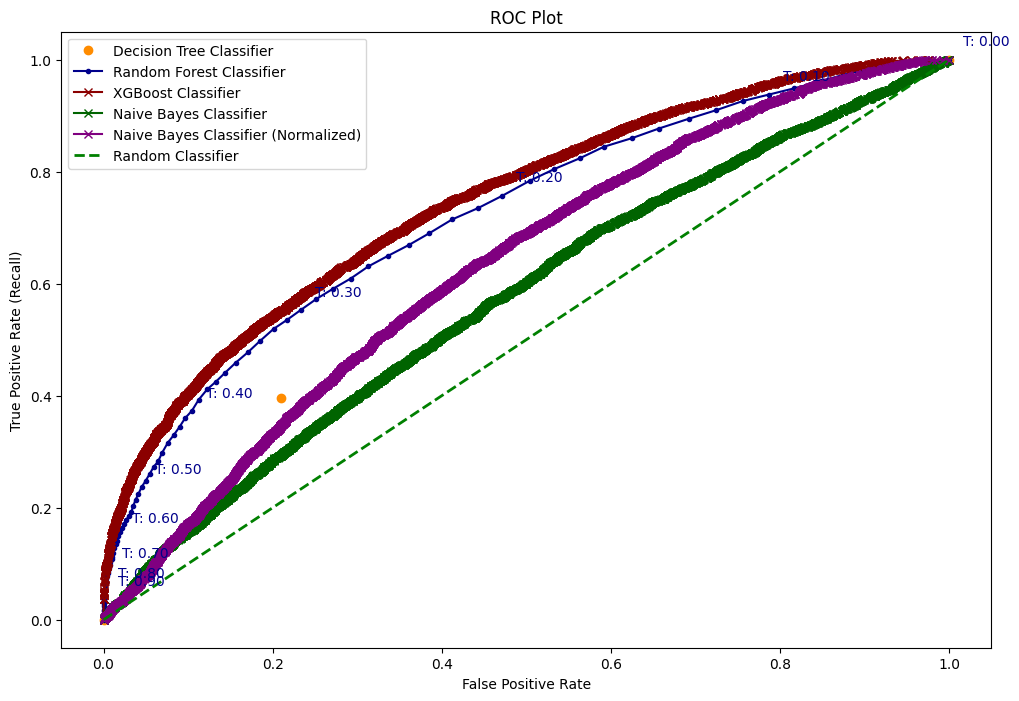

In [375]:
model_nb_norm_probs = model_nb_norm.predict_proba(X_test_norm)

model_nb_norm_probs = model_nb_norm_probs[:, 1]
model_nb_norm_fpr, model_nb_norm_tpr, _ = roc_curve(y_test_norm, model_nb_norm_probs)


plt.figure(figsize=(12, 8))
plt.plot(model_dt_fpr, model_dt_tpr, 's', marker='o',color='darkorange', label='Decision Tree Classifier')
plt.plot(model_rf_fpr, model_rf_tpr, marker='.',color='darkblue', label='Random Forest Classifier')
plt.plot(model_xgb_fpr, model_xgb_tpr, marker='x',color='darkred', label='XGBoost Classifier')
plt.plot(model_nb_fpr, model_nb_tpr, marker='x',color='darkgreen', label='Naive Bayes Classifier')
plt.plot(model_nb_norm_fpr, model_nb_norm_tpr, marker='x',color='purple', label='Naive Bayes Classifier (Normalized)')
for i in range(0, len(model_rf_thresholds), len(model_rf_thresholds)//10):
    if 1>=model_rf_thresholds[i]>=0:
      plt.annotate(f'T: {model_rf_thresholds[i]:.2f}', (model_rf_fpr[i], model_rf_tpr[i]),color='darkblue', textcoords="offset points", xytext=(10,10), ha='left')
plt.plot([0, 1], [0, 1], color='green', lw=2, linestyle='--', label='Random Classifier')


plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend()
plt.show()

The Naive Bayes Classifier is indeed giving better results after normalisation !

Let's try PCA for dimensionality reduction

In [380]:
from sklearn.decomposition import PCA


# Apply PCA
pca = PCA(n_components=5)  # Reduce to 2 principal components
X_train_pca = pca.fit_transform(X_train_norm)
X_test_pca = pca.fit_transform(X_test_norm)

model_nb_pca = GaussianNB()
model_nb_pca.fit(X=X_train_pca, y=y_train_norm)

y_pred = model_nb_pca.predict(X_test_pca)

print(classification_report(y_test_norm, y_pred))


              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86      9013
         1.0       0.55      0.01      0.02      2987

    accuracy                           0.75     12000
   macro avg       0.65      0.50      0.44     12000
weighted avg       0.70      0.75      0.65     12000



C:\Users\berrayan\AppData\Local\Temp\ipykernel_11724\2854748710.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  plt.plot(model_dt_fpr, model_dt_tpr, 's', marker='o',color='darkorange', label='Decision Tree Classifier')


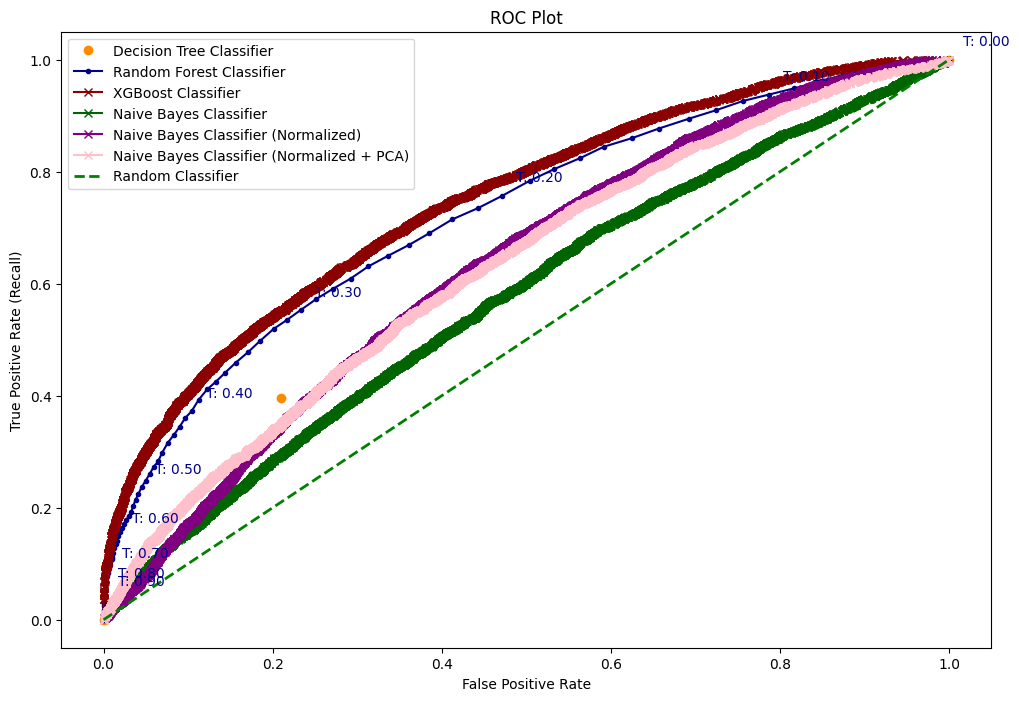

In [381]:
model_nb_pca_probs = model_nb_pca.predict_proba(X_test_pca)

model_nb_pca_probs = model_nb_pca_probs[:, 1]
model_nb_pca_fpr, model_nb_pca_tpr, _ = roc_curve(y_test_norm, model_nb_pca_probs)


plt.figure(figsize=(12, 8))
plt.plot(model_dt_fpr, model_dt_tpr, 's', marker='o',color='darkorange', label='Decision Tree Classifier')
plt.plot(model_rf_fpr, model_rf_tpr, marker='.',color='darkblue', label='Random Forest Classifier')
plt.plot(model_xgb_fpr, model_xgb_tpr, marker='x',color='darkred', label='XGBoost Classifier')
plt.plot(model_nb_fpr, model_nb_tpr, marker='x',color='darkgreen', label='Naive Bayes Classifier')
plt.plot(model_nb_norm_fpr, model_nb_norm_tpr, marker='x',color='purple', label='Naive Bayes Classifier (Normalized)')
plt.plot(model_nb_pca_fpr, model_nb_pca_tpr, marker='x',color='pink', label='Naive Bayes Classifier (Normalized + PCA)')
for i in range(0, len(model_rf_thresholds), len(model_rf_thresholds)//10):
    if 1>=model_rf_thresholds[i]>=0:
      plt.annotate(f'T: {model_rf_thresholds[i]:.2f}', (model_rf_fpr[i], model_rf_tpr[i]),color='darkblue', textcoords="offset points", xytext=(10,10), ha='left')
plt.plot([0, 1], [0, 1], color='green', lw=2, linestyle='--', label='Random Classifier')


plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend()
plt.show()

Removing 2 dimensionality indeed made the model better. We need to see if this generalises to bigger data and more features. Also, we need to study what would be the number of n components that is ideal. 